In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('/home/yzwang/MF/github')))
sys.path.append(os.path.abspath(os.path.join('/home/yzwang/MF/github/Method')))
import numpy as np
import torch
import torch.nn as nn
from datetime import datetime
from utils import (root_mean_squared_error, mean_absolute_error, create_lagged_data,
                   three_frequency_convert_to_lowest,plot_forecasts_multi)
from Baseline import set_seed,DNN3_G3

np.printoptions(precision=4, suppress=True)
np.set_printoptions(precision=4, suppress=True)
set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#data parameters
d1 = 20
d2 = 3
P1 = 13
P2 = 56
QP3 = 9
Q = 5
DD = d1*d2*P1+ d2*P2+ QP3


Pre-COVID

In [2]:
T = 188
T_val = 20
T_test = 20
T_train = T - T_val - T_test

T_M = T * d2
T_H = T * d1 * d2
print('T',T,'T_H:', T_H, 'T_M:', T_M)
print('T_train:', T_train, 'T_val:', T_val, 'T_test:', T_test)

Y = np.load(f'../data_clean/Y_std.npy')[:,:T]
X_M = np.load(f'../data_clean/X_M_std.npy')[:,:T*d2]
X_H = np.load(f'../data_clean/X_H_std.npy')[:,:T*d1*d2]

print('Y shape:', Y.shape)
print('X_M shape:', X_M.shape)
print('X_H shape:', X_H.shape)
print('Y max:', np.max(Y), 'Y min:', np.min(Y), 'Y mean:', np.mean(Y), 'Y std:', np.std(Y))
print('X_M max:', np.max(X_M), 'X_M min:', np.min(X_M), 'X_M mean:', np.mean(X_M), 'X_M std:', np.std(X_M))
print('X_H max:', np.max(X_H), 'X_H min:', np.min(X_H), 'X_H mean:', np.mean(X_H), 'X_H std:', np.std(X_H))


T 188 T_H: 11280 T_M: 564
T_train: 148 T_val: 20 T_test: 20
Y shape: (9, 188)
X_M shape: (56, 564)
X_H shape: (13, 11280)
Y max: 9.083060657379114 Y min: -4.5941919722762705 Y mean: 0.003900497296983884 Y std: 0.87206867900193
X_M max: 16.940348022306395 X_M min: -17.12817591268496 X_M mean: 0.00039118324278265517 X_M std: 0.8661968246394718
X_H max: 23.195031218753527 X_H min: -25.564933640672024 X_H mean: 7.850425864522082e-05 X_H std: 0.9699726059297447


Y_total shape: (957, 188)

----- Evaluating Direct Multi-Step Forecasting for Horizon = t+1 -----
==== Step 0
==== Step 1
==== Step 2
==== Step 3
==== Step 4
==== Step 5
==== Step 6
==== Step 7
==== Step 8
==== Step 9
==== Step 10
==== Step 11
==== Step 12
==== Step 13
==== Step 14
==== Step 15
==== Step 16
==== Step 17
==== Step 18
==== Step 19

=== Horizon 1 (Direct Forecast t+1) ===
True matrix:
 [[-0.1516  0.3905 -0.1324 -0.6072 -1.002 ]
 [ 0.2088  0.0433  0.642   0.2094 -0.4758]
 [-0.0477 -0.0281 -0.1132  0.6587  2.1758]
 [-0.2482 -0.0138 -0.1579  0.1172 -0.9528]
 [-0.446  -0.283  -0.3616 -0.0008 -0.8465]
 [-0.0842  0.0321 -0.3194  0.5813 -0.2115]
 [-0.3207 -0.2021 -0.3185 -0.6105  2.4701]
 [ 0.0345 -0.0215 -0.1056  0.0058 -1.417 ]
 [-0.1072 -0.1843  0.4641 -0.3055  0.6385]
 [-0.1689  0.0447 -0.2786 -0.8523  0.1926]
 [-0.1021 -0.2022  0.1775 -0.1767 -0.7769]
 [ 0.1067 -0.0376  0.2002 -0.3682  0.7686]
 [ 0.415   0.3369  0.2529  0.5607  0.1578]
 [ 0.1294  0.0043  0.1643 -0.2638  0.0

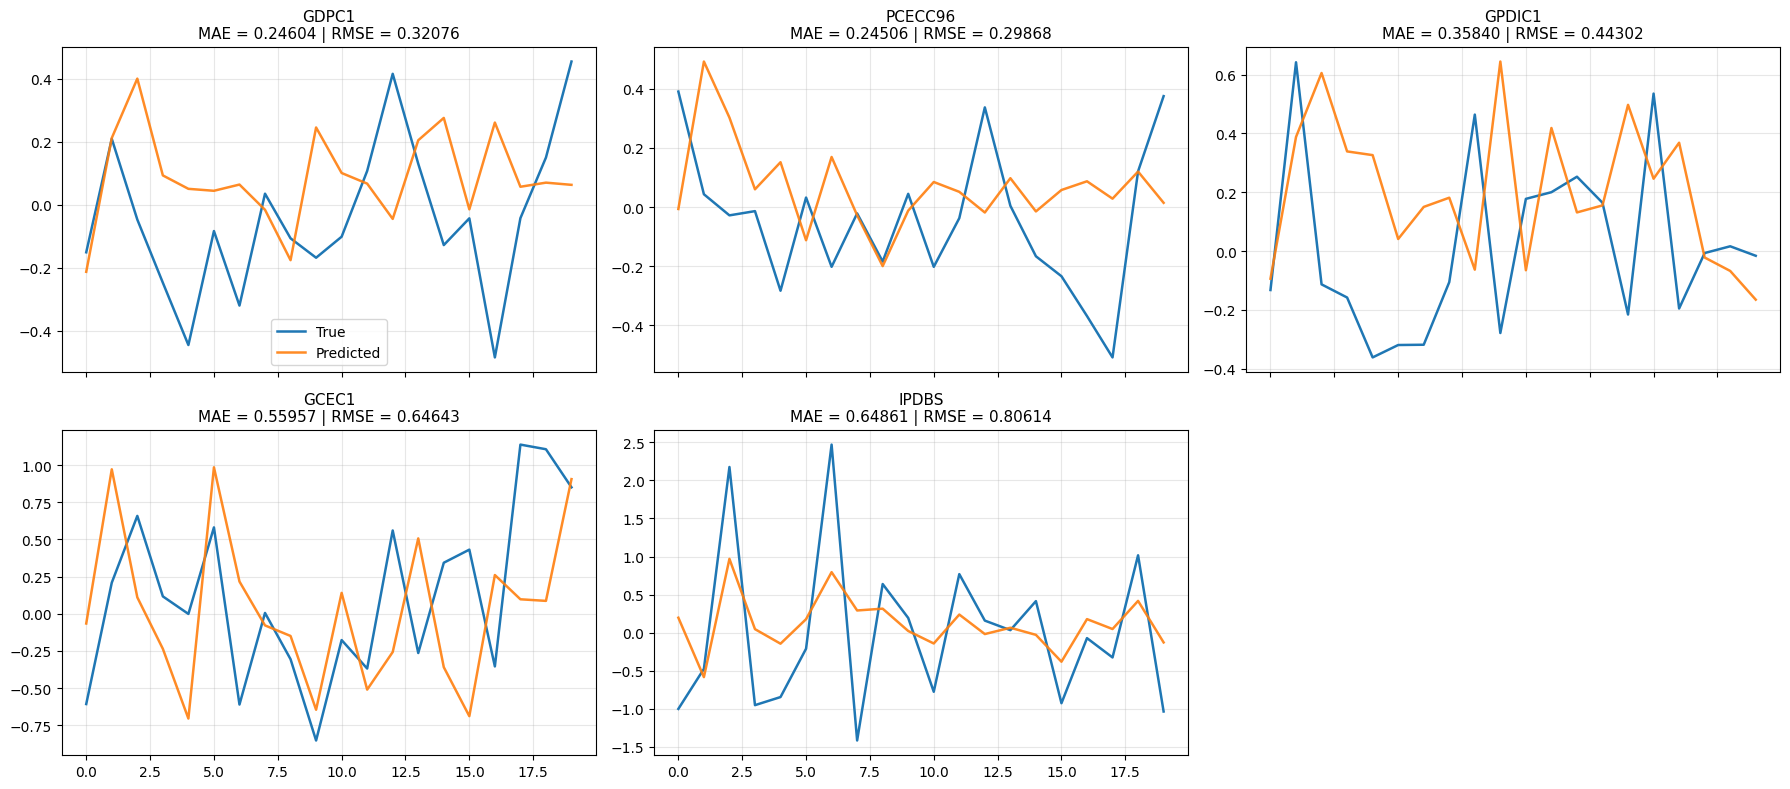


All direct multi-step forecasts and plots saved successfully.


In [3]:
EPOCHS = 100
LEARNING_RATE = 0.001
Hidden_dim = 128
k = 1
L3 = 2
hidden_dim = 128
eval_horizon = [0]
eval_horizon_len = len(eval_horizon)

Y_total = three_frequency_convert_to_lowest(Y, X_M, X_H, d1, d2)
print('Y_total shape:', Y_total.shape)
model = DNN3_G3(input_dim=DD*k, output_dim=Q, W=hidden_dim, L=L3).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
forecasts_multi = np.zeros((eval_horizon_len, Q, T_test))
# forecast_test_DNN = np.zeros((Q, T_test)) 
for i in range(eval_horizon_len):
    eval_horizon_curr = eval_horizon[i]
    target_horizon = int(eval_horizon_curr) + 1
    print(f'\n----- Evaluating Direct Multi-Step Forecasting for Horizon = t+{target_horizon} -----')

    for t in range(T_test):
        print(f'==== Step {t}')
        X_train_cur = Y_total[:,:T_train + T_val + t - target_horizon]
        X_train_lag_cur = create_lagged_data(X_train_cur, k)                #(P3*k, T_train + T_val+t-k) #(10,43)
        # print('X_L_train_lagged_cur', X_train_lag_cur.shape)  
        Y_train_cur = Y_total[:Q, k+ target_horizon-1:T_train + T_val + t]  #(P3, T_train + T_val+t-k) #(5,43)
        # print('Y_train_cur', Y_train_cur.shape)
        # print('X_train_lag_cur', X_train_lag_cur.shape)
        # Training phase
        model.train()
        for epoch in range(EPOCHS):
            optimizer.zero_grad()
            y_pred = model(torch.FloatTensor(X_train_lag_cur.T).to(device)).T
            loss = criterion(y_pred, torch.FloatTensor(Y_train_cur).to(device))
            loss.backward()
            optimizer.step()
        X_test_cur = Y_total[:, T_train + T_val + t - k- target_horizon+1:T_train + T_val + t- target_horizon+1].reshape(-1, 1)
        model.eval()
        with torch.no_grad():
            y_pred = model(torch.FloatTensor(X_test_cur.T).unsqueeze(0).to(device)).reshape(-1)  #(P3)
        forecasts_multi[i,:, t] = y_pred.cpu().numpy()

Y_true = Y_total[:Q, T_train + T_val:]
for h in range(eval_horizon_len):
    forecast_test = forecasts_multi[h]      # (Q, T_test - eval_horizon + 1)
    forecast_true = Y_true                  # (Q, T_test - eval_horizon + 1)

    err_MAE_t, err_MAE = mean_absolute_error(forecast_true, forecast_test)
    err_RMSE_t, err_RMSE = root_mean_squared_error(forecast_true, forecast_test)

    print(f"\n=== Horizon {h+1} (Direct Forecast t+{h+1}) ===")
    print("True matrix:\n", np.round(forecast_true.T, 4))
    print("Forecast matrix:\n", np.round(forecast_test.T, 4))
    print("\nMAE per series :", np.round(err_MAE_t, 4))
    print("RMSE per series:", np.round(err_RMSE_t, 4))
    print("Overall Mean MAE :", f"{err_MAE:.4f}")
    print("Overall Mean RMSE:", f"{err_RMSE:.4f}")

print(f'\n===================== DIRECT: k={k}, eval_horizon={eval_horizon} =====================')

now = datetime.now()
print('Current time:', now.strftime("%Y_total-%m-%d %H:%M"))

# === Plot forecasts for each horizon ===
for h in range(eval_horizon_len):
    plot_forecasts_multi(
        Y_true, forecasts_multi[h],
        save_path=f'../result/DNN_k{k}_horizon{h+1}.png',
        title_prefix=f'DNN Forecast (Horizon = {h+1})'
    )

print("\nAll direct multi-step forecasts and plots saved successfully.")


Post_COVID

In [4]:
T = 208
T_val = 20
T_test = 20
T_train = T - T_val - T_test

T_M = T * d2
T_H = T * d1 * d2
print('T',T,'T_H:', T_H, 'T_M:', T_M)
print('T_train:', T_train, 'T_val:', T_val, 'T_test:', T_test)

Y = np.load(f'../data_clean/Y_std.npy')[:,:T]
X_M = np.load(f'../data_clean/X_M_std.npy')[:,:T*d2]
X_H = np.load(f'../data_clean/X_H_std.npy')[:,:T*d1*d2]

print('Y shape:', Y.shape)
print('X_M shape:', X_M.shape)
print('X_H shape:', X_H.shape)
print('Y max:', np.max(Y), 'Y min:', np.min(Y), 'Y mean:', np.mean(Y), 'Y std:', np.std(Y))
print('X_M max:', np.max(X_M), 'X_M min:', np.min(X_M), 'X_M mean:', np.mean(X_M), 'X_M std:', np.std(X_M))
print('X_H max:', np.max(X_H), 'X_H min:', np.min(X_H), 'X_H mean:', np.mean(X_H), 'X_H std:', np.std(X_H))


T 208 T_H: 12480 T_M: 624
T_train: 168 T_val: 20 T_test: 20
Y shape: (9, 208)
X_M shape: (56, 624)
X_H shape: (13, 12480)
Y max: 9.083060657379114 Y min: -8.981419418585231 Y mean: -7.591268544445516e-18 Y std: 1.0
X_M max: 24.694614539572694 X_M min: -24.295703738737302 X_M mean: 3.100897642039128e-18 X_M std: 1.0
X_H max: 30.816445727888585 X_H min: -33.0391984692243 X_H mean: -1.25255930983351e-17 X_H std: 1.0000000000000169


Y_total shape: (957, 208)

----- Evaluating Direct Multi-Step Forecasting for Horizon = t+1 -----
==== Step 0
==== Step 1
==== Step 2
==== Step 3
==== Step 4
==== Step 5
==== Step 6
==== Step 7
==== Step 8
==== Step 9
==== Step 10
==== Step 11
==== Step 12
==== Step 13
==== Step 14
==== Step 15
==== Step 16
==== Step 17
==== Step 18
==== Step 19

=== Horizon 1 (Direct Forecast t+1) ===
True matrix:
 [[ 0.0094 -0.0574 -0.5375  0.4535 -0.0691]
 [-1.9047 -2.2082 -0.8595  0.7866 -0.0862]
 [-8.1907 -8.9814 -3.9476  2.0583 -3.3639]
 [ 6.3158  7.1969  4.0204 -2.3905  6.0163]
 [ 0.3765  0.6239  0.5493 -0.9811 -1.2441]
 [ 0.6448  1.4071 -0.3649  1.0205  2.32  ]
 [ 0.8169  2.3501 -0.6214 -1.8182  0.6188]
 [ 0.1653  0.0531  0.7308 -0.9843 -0.3972]
 [ 1.0276  0.3341  1.3441 -0.6027  0.7771]
 [-0.8525 -0.4331  0.2323 -1.546   1.02  ]
 [-0.5509 -0.0735 -0.7694 -0.9696  0.7022]
 [ 0.0014 -0.308  -0.5795 -0.0493 -3.956 ]
 [ 0.1425 -0.3764  0.1376  1.0772 -0.4086]
 [ 0.0186  0.4471 -0.7935  0.9776  0.0

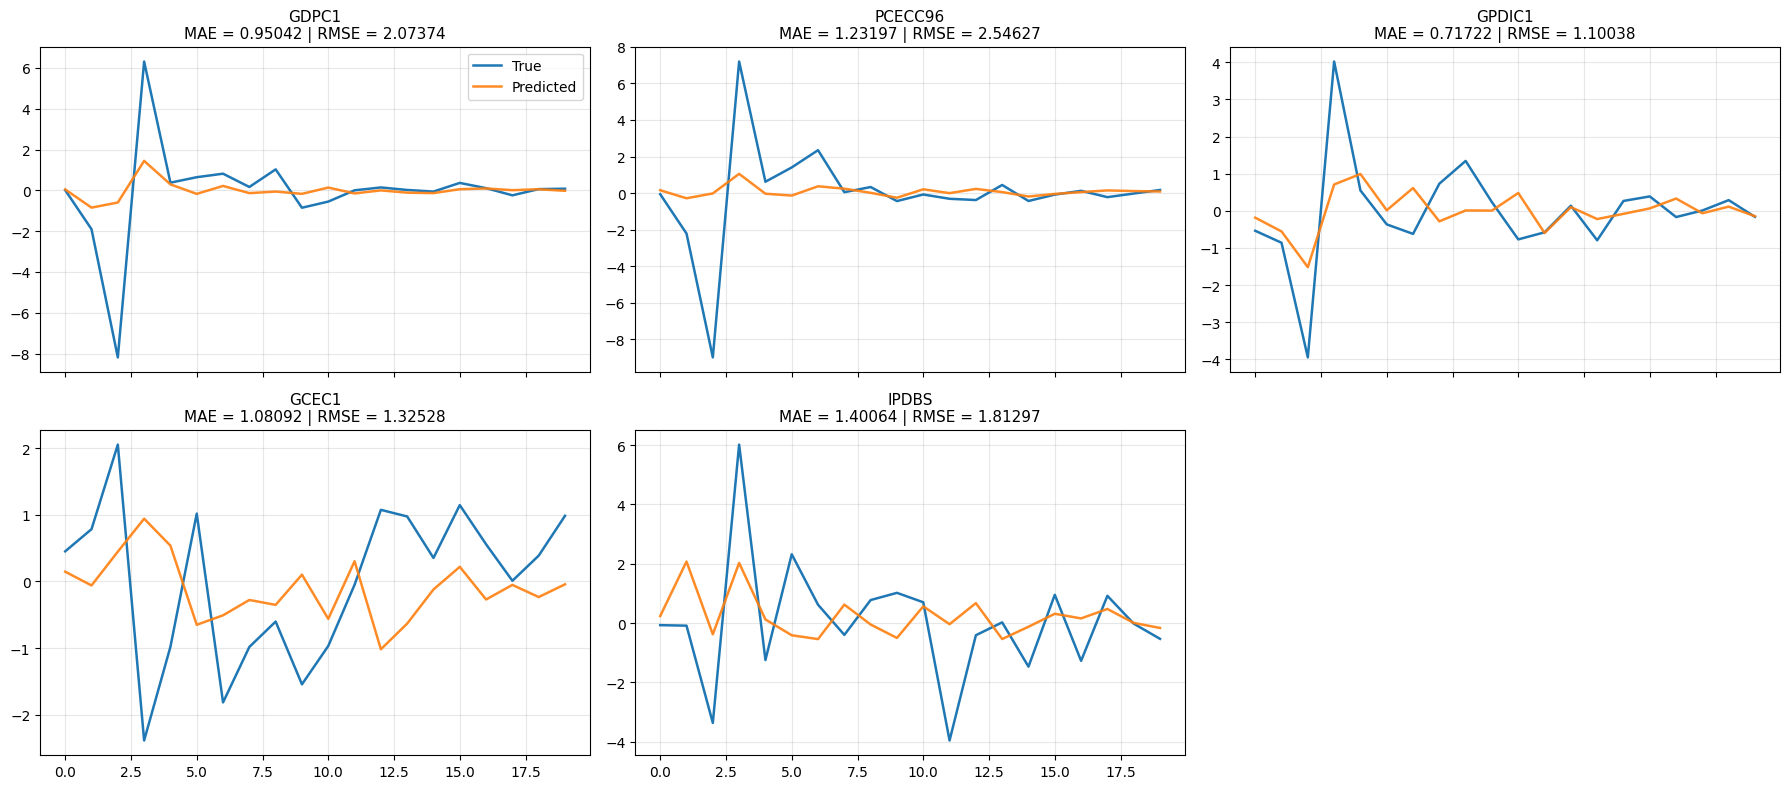


All direct multi-step forecasts and plots saved successfully.


In [5]:
EPOCHS = 100
LEARNING_RATE = 0.001
Hidden_dim = 128
k = 1
L3 = 2
hidden_dim = 128
eval_horizon = [0]
eval_horizon_len = len(eval_horizon)

Y_total = three_frequency_convert_to_lowest(Y, X_M, X_H, d1, d2)
print('Y_total shape:', Y_total.shape)
model = DNN3_G3(input_dim=DD*k, output_dim=Q, W=hidden_dim, L=L3).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
forecasts_multi = np.zeros((eval_horizon_len, Q, T_test))
# forecast_test_DNN = np.zeros((Q, T_test)) 
for i in range(eval_horizon_len):
    eval_horizon_curr = eval_horizon[i]
    target_horizon = int(eval_horizon_curr) + 1
    print(f'\n----- Evaluating Direct Multi-Step Forecasting for Horizon = t+{target_horizon} -----')

    for t in range(T_test):
        print(f'==== Step {t}')
        X_train_cur = Y_total[:,:T_train + T_val + t - target_horizon]
        X_train_lag_cur = create_lagged_data(X_train_cur, k)  #(P3*k, T_train + T_val+t-k) #(10,43)
        # print('X_L_train_lagged_cur', X_train_lag_cur.shape)  
        Y_train_cur = Y_total[:Q, k+ target_horizon-1:T_train + T_val + t]  #(P3, T_train + T_val+t-k) #(5,43)
        # print('Y_train_cur', Y_train_cur.shape)
        # print('X_train_lag_cur', X_train_lag_cur.shape)
        # Training phase
        model.train()
        for epoch in range(EPOCHS):
            optimizer.zero_grad()
            y_pred = model(torch.FloatTensor(X_train_lag_cur.T).to(device)).T
            loss = criterion(y_pred, torch.FloatTensor(Y_train_cur).to(device))
            loss.backward()
            optimizer.step()
        X_test_cur = Y_total[:, T_train + T_val + t - k- target_horizon+1:T_train + T_val + t- target_horizon+1].reshape(-1, 1)
        model.eval()
        with torch.no_grad():
            y_pred = model(torch.FloatTensor(X_test_cur.T).unsqueeze(0).to(device)).reshape(-1)  #(P3)
        forecasts_multi[i,:, t] = y_pred.cpu().numpy()

Y_true = Y_total[:Q, T_train + T_val:]
for h in range(eval_horizon_len):
    forecast_test = forecasts_multi[h]      # (Q, T_test - eval_horizon + 1)
    forecast_true = Y_true          # (Q, T_test - eval_horizon + 1)

    err_MAE_t, err_MAE = mean_absolute_error(forecast_true, forecast_test)
    err_RMSE_t, err_RMSE = root_mean_squared_error(forecast_true, forecast_test)

    print(f"\n=== Horizon {h+1} (Direct Forecast t+{h+1}) ===")
    print("True matrix:\n", np.round(forecast_true.T, 4))
    print("Forecast matrix:\n", np.round(forecast_test.T, 4))
    print("\nMAE per series :", np.round(err_MAE_t, 4))
    print("RMSE per series:", np.round(err_RMSE_t, 4))
    print("Overall Mean MAE :", f"{err_MAE:.4f}")
    print("Overall Mean RMSE:", f"{err_RMSE:.4f}")

print(f'\n===================== DIRECT: k={k}, eval_horizon={eval_horizon} =====================')

now = datetime.now()
print('Current time:', now.strftime("%Y_total-%m-%d %H:%M"))

# === Plot forecasts for each horizon ===
for h in range(eval_horizon_len):
    plot_forecasts_multi(
        Y_true, forecasts_multi[h],
        save_path=f'../result/DNN_k{k}_horizon{h+1}.png',
        title_prefix=f'DNN Forecast (Horizon = {h+1})'
    )

print("\nAll direct multi-step forecasts and plots saved successfully.")
